### The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import uniform, loguniform, norm
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import corner
from IPython.display import display, Markdown

In [26]:
data = np.load("../solutions/transient.npy")
time = data[:, 0]
flux = data[:, 1]
flux_err = data[:, 2]

In [27]:
#Define the models, priors, likelihood and posterior

def BurstModel(params, t):
    b, A, t_0, alpha = params
    y = np.zeros(len(t))
    
    for i in range(0, len(t)):
        if t[i] < t_0:
            y[i] = b
        
        else:
            y[i] = b + A * np.exp(-alpha * (t[i] - t_0))
        
    return y


def GaussModel(params, t):
    b, A, t_0, sigma_w = params

    return b + A * np.exp(-(t - t_0)**2 / (2 * sigma_w**2))


def LogLikelihood(params, data, model):
    t, f, f_err = data.T
    # lnorm = -0.5 * np.log(2 * np.pi * f_err**2)
    logL = np.sum(-(f - model(params, t))**2 / (2 * f_err**2))

    return logL
    

#Prior transforms

def PriorTransformBurst(u):
    x = u.copy()
    
    x[0] = u[0] * 50
    x[1] = u[1] * 50 
    x[2] = u[2] * 100
    x[3] = loguniform(np.exp(-5), np.exp(5)).ppf(u[3])
    
    return x


def PriorTransformGauss(u):
    x = u.copy()
    
    x[0] = u[0] * 50
    x[1] = u[1] * 50 
    x[2] = u[2] * 100
    x[3] = loguniform(np.exp(-2), np.exp(2)).ppf(u[3])
    
    return x

## Burst model

In [29]:
#Run the nested sampler for the burst model

n_dim = 4

sampler_burst = dynesty.NestedSampler(LogLikelihood, PriorTransformBurst, n_dim, logl_args=[data, BurstModel], bootstrap=0)
sampler_burst.run_nested()

7745it [01:11, 107.59it/s, +500 | bound: 50 | nc: 1 | ncall: 56777 | eff(%): 14.651 | loglstar:   -inf < -48.769 <    inf | logz: -63.464 +/-  0.168 | dlogz:  0.001 >  0.509]


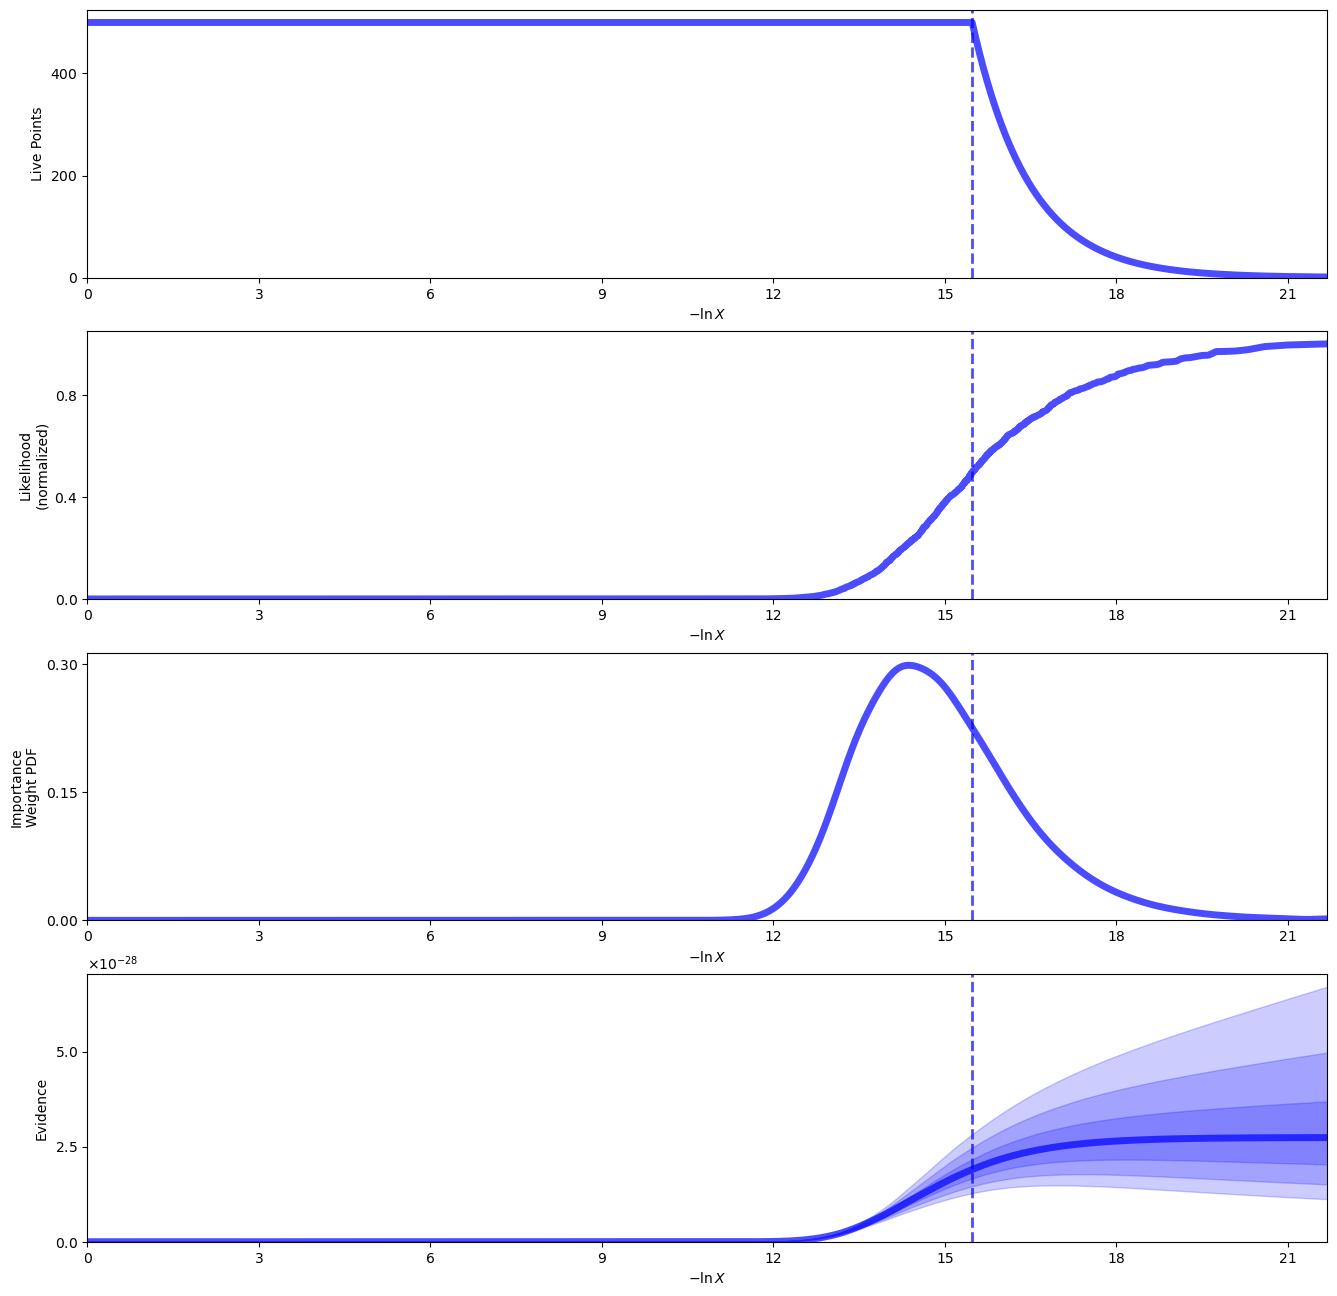

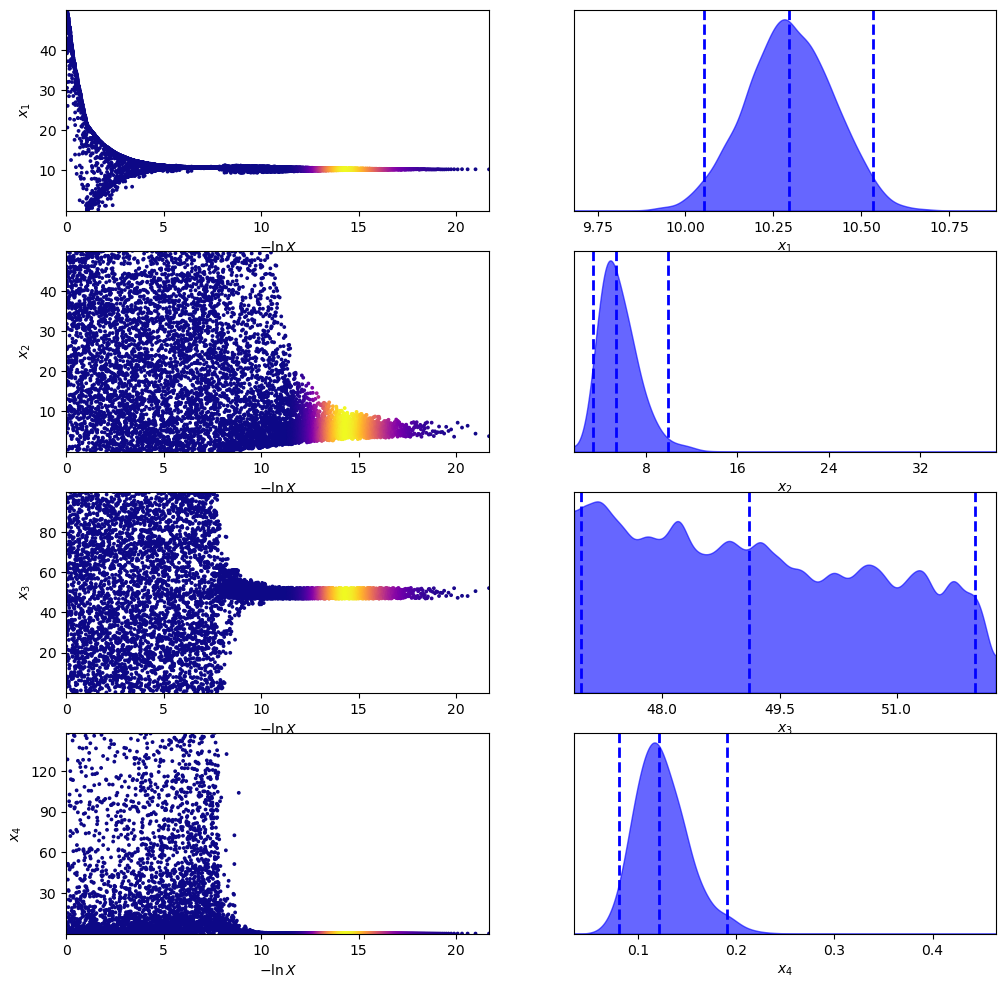

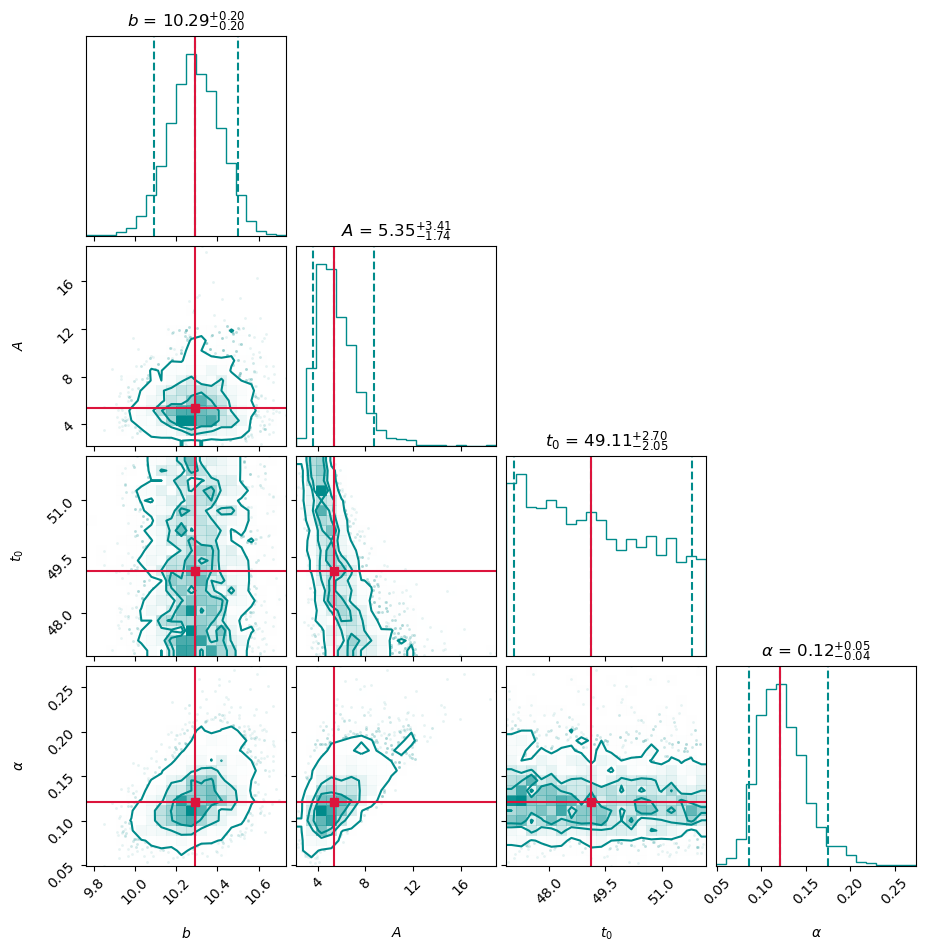

In [30]:
#Get samples and weights then plot

s_res_burst = sampler_burst.results
samples_burst = s_res_burst.samples
w_burst = np.exp(s_res_burst.logwt - s_res_burst.logz[-1])
samples_burst_eq = dyfunc.resample_equal(samples_burst, w_burst)

dyplot.runplot(s_res_burst)

burst_fig, burst_axes = dyplot.traceplot(s_res_burst)

#Median and 90% credible region

medians_b = np.array([np.median(samples_burst_eq[:, i]) for i in range(0, n_dim)])
regions_90_b = np.array([corner.quantile(samples_burst_eq[:, i], [0.05, 0.95]) for i in range(0, n_dim)])

#Cornerplot

fig_corner_b = corner.corner(samples_burst_eq, show_titles=True, 
                             labels=[r"$b$", r"$A$", r"$t_0$", r"$\alpha$"], 
                             quantiles=[0.05, 0.50, 0.95], 
                             levels=[0.39, 0.68, 0.95], 
                             truths=medians_b,
                             color="darkcyan", truth_color="crimson")

## Gaussian model

In [32]:
#Run nested sampler for the gaussian model

sampler_gauss = dynesty.NestedSampler(LogLikelihood, PriorTransformGauss, n_dim, logl_args=[data, GaussModel], bootstrap=0)
sampler_gauss.run_nested()

8106it [01:01, 131.18it/s, +500 | bound: 44 | nc: 1 | ncall: 51631 | eff(%): 16.831 | loglstar:   -inf < -52.435 <    inf | logz: -67.906 +/-  0.175 | dlogz:  0.001 >  0.509]


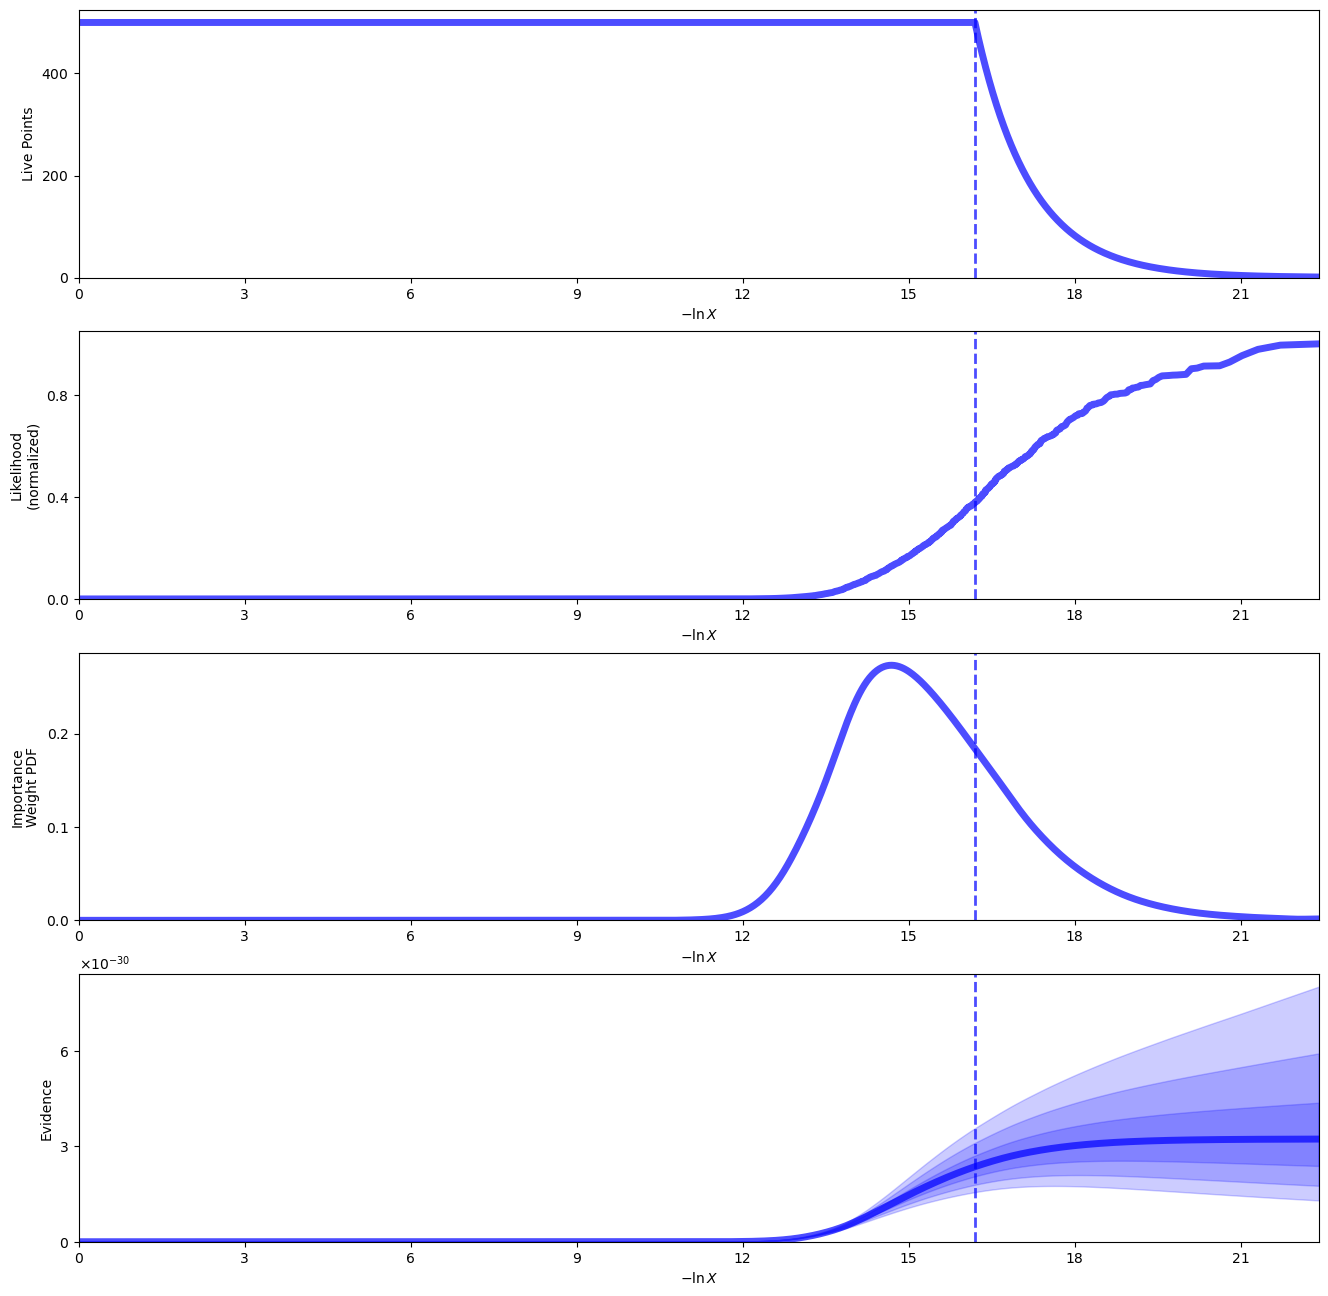

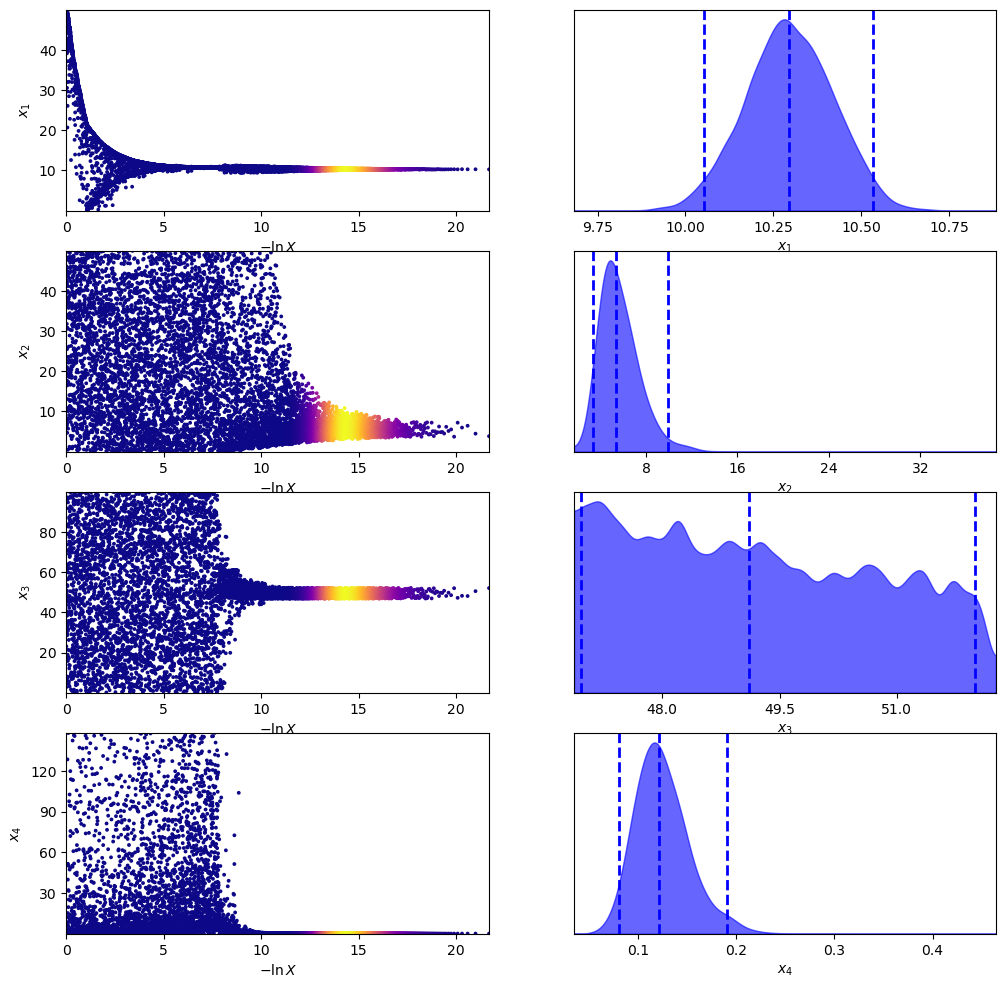

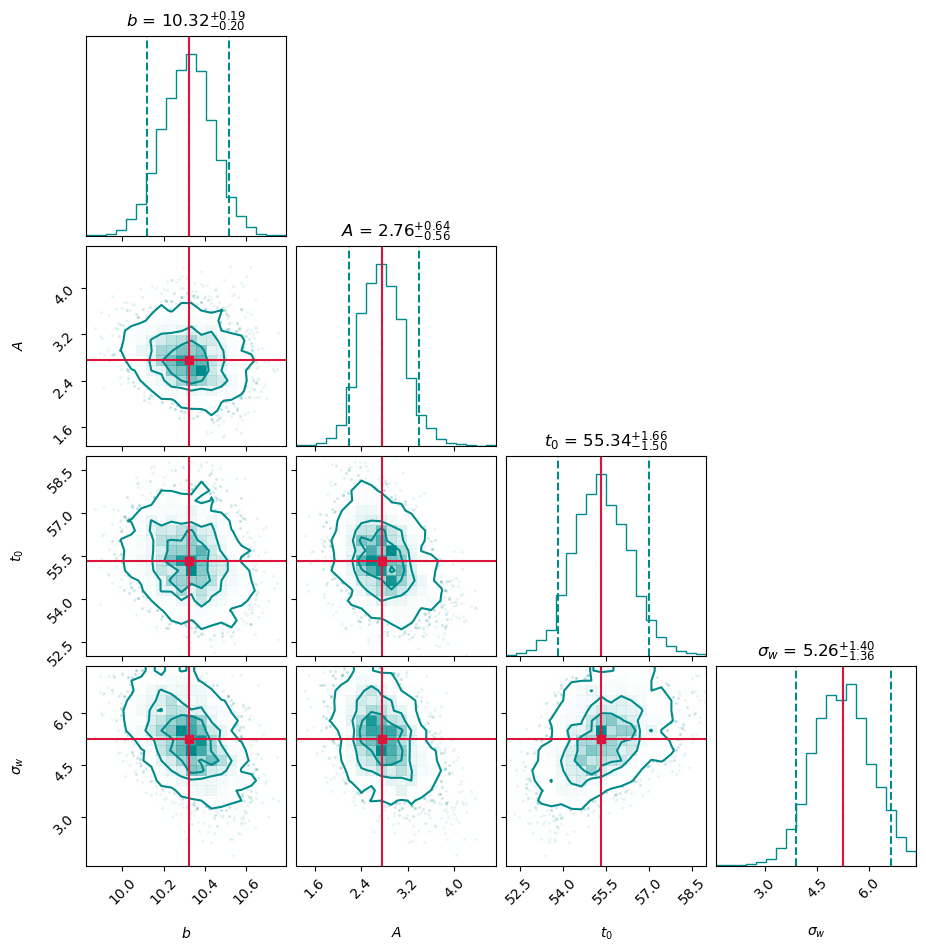

In [33]:
#Get samples and weights then plot

s_res_gauss = sampler_gauss.results
samples_gauss = s_res_gauss.samples
w_gauss = np.exp(s_res_gauss.logwt - s_res_gauss.logz[-1])
samples_gauss_eq = dyfunc.resample_equal(samples_gauss, w_gauss)

dyplot.runplot(s_res_gauss)

gauss_fig, gauss_axes = dyplot.traceplot(s_res_burst)

#Median and 90% credible region

medians_g = np.array([np.median(samples_gauss_eq[:, i]) for i in range(0, n_dim)])
regions_90_g = np.array([corner.quantile(samples_gauss_eq[:, i], [0.05, 0.95]) for i in range(0, n_dim)])

#Cornerplot

fig_corner_g = corner.corner(samples_gauss_eq, show_titles=True, 
                             labels=[r"$b$", r"$A$", r"$t_0$", r"$\sigma_w$"], 
                             quantiles=[0.05, 0.50, 0.95], 
                             levels=[0.39, 0.68, 0.95], 
                             truths=medians_g,
                             color="darkcyan", truth_color="crimson")

In [34]:
#Compute the Bayes factor

Z_burst = np.exp(s_res_burst.logz[-1])
Z_gauss = np.exp(s_res_gauss.logz[-1])
B_bg = Z_burst / Z_gauss

print("Burst model evidence = ", Z_burst)
print("Gaussian model evidence = ", Z_gauss)
print("Log Bayes factor = ", np.log(B_bg))

Burst model evidence =  2.7398702952614472e-28
Gaussian model evidence =  3.2259927183542775e-30
Log Bayes factor =  4.441840045246067


The burst model has $\textbf{"very strong"}$ evidence in its favour $\left( 3.4 \leq \ln{B_{bg}} \leq 4.6 \right)$